# Identifying Gene Co-Expression Modules in the Developing Human Brain
    
**Course**: MED263, "Bioinformatics Applications to Human Disease"  
**Preparer**: Kevin Chau (kkchau@ucsd.edu) (https://github.com/kkchau/MED263)

# Introduction
Gene co-expression networks are highly informative in the context of biological processes as well as identifying risk genes through a guilty-by-association framework. These co-expression networks are constructed such that nodes represent the elements of interest, the genes, and edges represent correlations between the expression patterns of those genes. A straighforward approach to the construction of these gene co-expression networks would consist of calculating pairwise correlations, e.g. Pearson correlations, and applying a hard threshold such that edges only exists between nodes that have a correlation that surpasses the threshold. However, this approach comes with the caveat of lost information. For example, if two genes exhibit a correlation very close to, but not meeting, an established threshold, that potential edge is lost.   
In this practical, we will be using R, specifically the Weighted Gene Co-Expression Network Analysis (WGCNA) package, to identify and characterize gene co-expression modules from human brain developmental transcriptome expression data. We will be using publicly available gene expression data from the BrianSpan Atlas, creating the networks with WGCNA in R, and characterizing these modules with ENRICHR.

## Set-Up
We will be using WGCNA for the actual network construction; data will be organized into "Summarized Experiment" objects for ease of use. 
All of the following packages should already be installed if running from the corresponding Docker container

In [3]:
# install.packages(c("matrixStats", "Hmisc", "splines", "foreach", "doParallel", "fastcluster", "dynamicTreeCut", "survival"))

In [4]:
# source("https://bioconductor.org/biocLite.R")

In [5]:
# biocLite("WGCNA")
# biocLite("SummarizedExperiment")

### Libraries

In [6]:
library(WGCNA)
library(SummarizedExperiment)

Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust




*
*  Package WGCNA 1.62 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=2
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=2
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*





Attaching package: ‘WGCNA’

The following object is masked from ‘package:stats’:

    cor

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff,

In [7]:
### Optional:
# Enable parallel processing for computationally intensive tasks (soft thresholding, topological overlap, etc.)
# Go to your Docker settings (Settings -> Advanced) and check how many CPUs you would like to dedicate to the process
# Then, uncomment and run the following lines
# library(doParallel)
# enableWGCNAThreads()

# Data

## Initial Data Structuring
To begin the data analysis, we will first download and extract gene expression data from the BrainSpan Atlas

In [8]:
#url <- "http://www.brainspan.org/api/v2/well_known_file_download/267666525"
#utils::download.file(url, destfile="brainSpan.zip", mode='wb')
#utils::unzip("brainSpan.zip", exdir="brainSpan")
#file.remove("brainSpan.zip")

The downloaded files consist of a RPKM expression matrix, sample metadata, and row metadata, along with a readme file.

### Question 1.
How were expressions determined (what tools were used for alignment, quantification) and what was the reference?
### Answer
Read alignment was performed with Tophat using Gencode v10 annotations; quantification was done with SAMtools and RSEQtools (this can be found in the whitepaper from https://brainspan.org)

Next, we want to package the relevant data and metadata together into a single SummarizedExperiment. This is done to protect the integrity of the data and safeguard value mappings, yielding a nice reference in case any downstream analysis goes wrong.

In [9]:
expr <- read.csv("brainSpan/expression_matrix.csv", header=FALSE)[, -1]
coldata <- read.csv("brainSpan/columns_metadata.csv")[, -1]
rowdata <- read.csv("brainSpan/rows_metadata.csv")[, -1]
head(expr)
head(coldata)
head(rowdata)

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,⋯,V516,V517,V518,V519,V520,V521,V522,V523,V524,V525
36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,⋯,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
0.044081,0.067338,0.000000,0.145466,0.185188,0.311180,0.000000,0.000000,0.473831,0.181220,⋯,0.758571,0.000000,0.061869,0.026876,0.100691,0.140675,0.300576,0.126526,0.000000,0.424134
34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,⋯,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,⋯,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,⋯,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,0.260205,⋯,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879


donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
13058,H376.IIA.51,8 pcw,M,10268,Ocx,occipital neocortex
13058,H376.IIA.51,8 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples)
13058,H376.IIA.51,8 pcw,M,10361,AMY,amygdaloid complex
13058,H376.IIA.51,8 pcw,M,10550,MGE,medial ganglionic eminence
13058,H376.IIA.51,8 pcw,M,10243,STC,posterior (caudal) superior temporal cortex (area 22c)
13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip


gene_id,ensembl_gene_id,gene_symbol,entrez_id
7062,ENSG00000000003,TSPAN6,7105
40735,ENSG00000000005,TNMD,64102
8736,ENSG00000000419,DPM1,8813
36423,ENSG00000000457,SCYL3,57147
35021,ENSG00000000460,C1orf112,55732
2253,ENSG00000000938,FGR,2268


In [10]:
row.names(expr) <- rowdata$ensembl_gene_id
colnames(expr) <- as.character(apply(coldata, 1, FUN=function(x) paste(x[["donor_name"]], x[["structure_acronym"]], sep=".")))
se.expr <- SummarizedExperiment(assays=list(rpkm=as.matrix(expr)), rowData=rowdata, colData=coldata)
se.expr

class: SummarizedExperiment 
dim: 52376 524 
metadata(0):
assays(1): rpkm
rownames(52376): ENSG00000000003 ENSG00000000005 ... ENSGR0000248421
  ENSGR0000249358
rowData names(4): gene_id ensembl_gene_id gene_symbol entrez_id
colnames(524): H376.IIA.51.Ocx H376.IIA.51.M1C-S1C ... H376.XI.56.STR
  H376.XI.56.S1C
colData names(7): donor_id donor_name ... structure_acronym
  structure_name

The se.expr SummarizedExperiment object is essentially a collection of matrices linked by the appropriate mappings; that is, the columns of the assays (in this case, the rpkm assay) correspond to the "colnames" of the SummarizedExperiment, which in turn have the attributes listed in the "colData" field. The same concept applies to the rownames and rowData.

# Methods and Results

## Data filtering 

### Expression filtering
Now, we will filter this expression data for lowly expressed genes since these features are likely representative of noise in the dataset. Additionally, this will reduce the size of the data and make it more managable for the more computationally intensive steps to follow. We first plot the density plot of the expression distribution to identify a suitable cutoff value. 

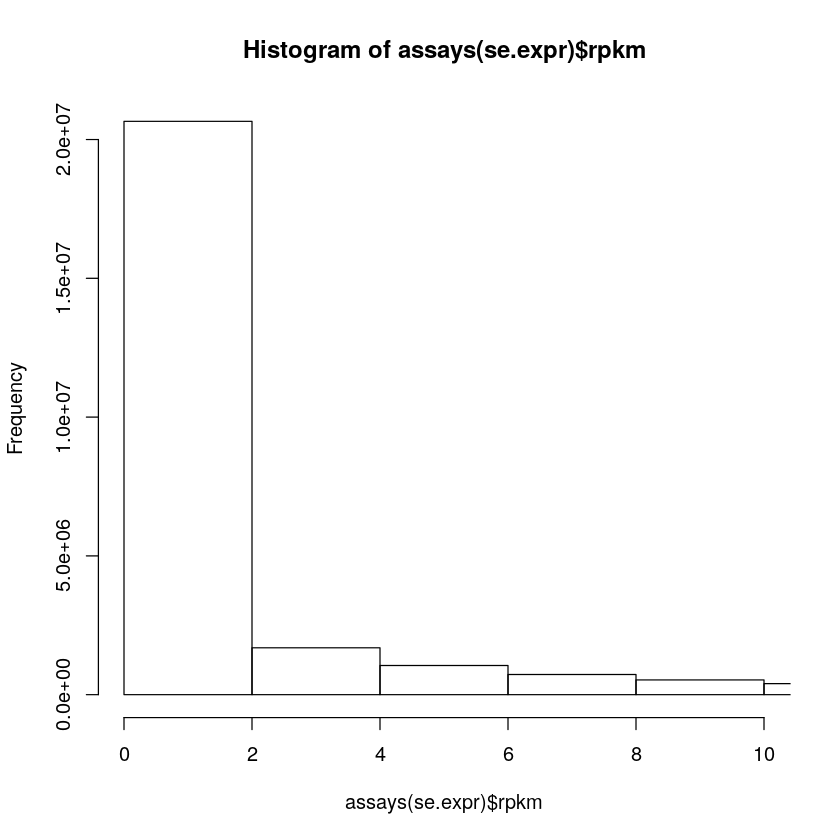

In [11]:
hist(assays(se.expr)$rpkm, xlim=c(0, 10), breaks=100000)

Given this plot we select an expression cutoff of 5 RPKM in at moste 90% of samples (this is a very strict threshold, but it is necessary to reduce the data to a manageable size for the default Docker memory settings).

In [12]:
se.expr.filt <- se.expr[apply(assays(se.expr)$rpkm <= 5, 1, sum) <= 0.9*ncol(se.expr),]

In [13]:
dim(se.expr.filt)
object.size(se.expr.filt)

[1] 12711   524

7325240 bytes

### Sample clustering
We will now perform sample-wise clustering to identify any outlier samples, reducing the noise in the dataset as well as its size.  
NOTE: This will take a significant amount of time if not using parallel processing

In [ ]:
sampleClust <- hclust(dist(assays(se.expr)$rpkm), method='average')

### Question 2
Which five genes have the highest overall (average across samples) expression?

### Answer

## Soft Thresholding
A stipulation of WGCNA network construction is that the data should satisfy the scale-free topology criteria. Scale-free networks are networks whose degree distributions (the number of neighbors per node) follows a power function, such that there are few nodes with a large number of neighbors whereas the rest of the nodes have few neighbors. This gives rise to "network hubs," and biologically this implies that there are fewer "vulnerable" genes such that their disruption results in the shutting down of a pathway, for example.  
This step consists of testing this topology on our data for different integer power levels. We want to select a power level that sufficiently satisfies the scale-free topology while still preserving connectivity.  
NOTE: This will take a while to run. If possible, enable parallel processing with enableWGCNAThreads().

In [ ]:
pwr <- c(seq(1, 15), seq(16, 24, by=2))
in.expr <- t(assays(se.expr.filt)$rpkm)
soft.thresh <- pickSoftThreshold(in.expr, powerVector=pwr, networkType="signed", verbose=5)

pickSoftThreshold: will use block size 3519.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3519 of 12711


Warning message:
“executing %dopar% sequentially: no parallel backend registered”

In [1]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux buster/sid

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_3.4.3       magrittr_1.5         IRdisplay_0.4.9000  
 [4] pbdZMQ_0.3-2         tools_3.4.3          crayon_1.3.4        
 [7] uuid_0.1-2           stringi_1.1.6        IRkernel_0.8.12.9000
[10] jsonlite_1.5         stringr_1.3.0